In [1]:
!pip install tensorflow


  Running setup.py bdist_wheel for protobuf: started
  Running setup.py bdist_wheel for protobuf: finished with status 'done'
  Stored in directory: C:\Users\joshua.chen\AppData\Local\pip\Cache\wheels\1b\42\a0\4c7343df5b629ec9c75655468dce7652b28026896b0209ba55
  Running setup.py bdist_wheel for html5lib: started
  Running setup.py bdist_wheel for html5lib: finished with status 'done'
  Stored in directory: C:\Users\joshua.chen\AppData\Local\pip\Cache\wheels\6f\85\6c\56b8e1292c6214c4eb73b9dda50f53e8e977bf65989373c962
  Running setup.py bdist_wheel for markdown: started
  Running setup.py bdist_wheel for markdown: finished with status 'done'
  Stored in directory: C:\Users\joshua.chen\AppData\Local\pip\Cache\wheels\b9\4f\6c\f4c1c5207c1d0eeaaf7005f7f736620c6ded6617c9d9b94096
Successfully built protobuf html5lib markdown
  Found existing installation: html5lib 0.999
    Uninstalling html5lib-0.999:
      Successfully uninstalled html5lib-0.999


    DEPRECATION: Uninstalling a distutils installed project (html5lib) has been deprecated and will be removed in a future version. This is due to the fact that uninstalling a distutils project will only partially uninstall the project.


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# tf core tutorial

In [30]:
node1 = tf.constant(3.0, dtype=tf.float32)
node2 = tf.constant(4.0) # also tf.float32 implicitly
#並沒有如想像的印出 3.0,4.0，只有當賦值(evaluate)後才會出現3.0,4.0
print(node1, node2)
#Tensor("Const:0", shape=(), dtype=float32) Tensor("Const_1:0", shape=(), dtype=float32)
#session include control and state of tf runtime
sess = tf.Session()
print(sess.run([node1, node2]))
#operaton is also node
node3 = tf.add(node1,node2)
print("node3 is :",node3)
print("sess.run(node3): ",sess.run(node3))
#placeholder 一開始沒有值，只有當計算時才會給值進去
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
#有點類似lambda概念
# + provides a shortcut for tf.add(a, b)
adder_node = a+b
print(sess.run(adder_node, {a: 3, b:4.5}))
print(sess.run(adder_node, {a: [1,3], b: [2, 4]}))
#可以一層層疊上去，這樣的設計是因為希望在ML的model裡能夠take arbitrary(任意的) inputs
add_and_triple = adder_node ** 3
print(sess.run(add_and_triple, {a: 3, b:4.5}))
#Variables讓我們能夠在訓練模型下，持續調整參數，讓我們達到相同inputs但卻有不同的outputs
W = tf.Variable([.3], dtype=tf.float32)
b = tf.Variable([-.3], dtype=tf.float32)
x = tf.placeholder(tf.float32)
linear_model = W * x + b
#與constant不同的是，constant一開始就被初始化了，Variables並沒有，所以要呼叫一個initialize function
init = tf.global_variables_initializer()
sess.run(init)
#賦值時一定要是dict型別
print(sess.run(linear_model,{x:[1,2,3,4]}))
#為了評估模型的正確性，需要一個y placeholder
y = tf.placeholder(tf.float32)
squared_deltas = tf.square(linear_model - y)
#加總所有的誤差平方
loss = tf.reduce_sum(squared_deltas)
print(sess.run(loss, {x:[1,2,3,4], y:[0,-1,-2,-3]}))
#從新指派新的值給W,b
fixW = tf.assign(W, [-1.])
fixb = tf.assign(b, [1.])
sess.run([fixW, fixb])
print(sess.run(loss, {x:[1,2,3,4], y:[0,-1,-2,-3]}))


Tensor("Const_34:0", shape=(), dtype=float32) Tensor("Const_35:0", shape=(), dtype=float32)
[3.0, 4.0]
node3 is : Tensor("Add_13:0", shape=(), dtype=float32)
sess.run(node3):  7.0
7.5
[ 3.  7.]
421.875
[ 0.          0.30000001  0.60000002  0.90000004]
23.66
[array([-1.], dtype=float32), array([ 1.], dtype=float32)]
0.0


# train.api

In [31]:
#這邊使用gradient decent方法來最小化loss function
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)
sess.run(init) # reset values to incorrect defaults. 若不初始化會得到剛被指派的變數W=-1,b=1
#x:[1,2,3,4],y:[0,-1,-2,-3]is training data
for i in range(1000):
    sess.run(train, {x:[1,2,3,4], y:[0,-1,-2,-3]})

print(sess.run([W, b]))
curr_W, curr_b, curr_loss = sess.run([W, b, loss], {x:[1,2,3,4], y:[0,-1,-2,-3]})
print("W: %s b: %s loss: %s"%(curr_W, curr_b, curr_loss))

[array([-0.9999969], dtype=float32), array([ 0.99999082], dtype=float32)]
W: [-0.9999969] b: [ 0.99999082] loss: 5.69997e-11


# tf.contrib.learn ==> high-level

In [35]:
#1.running training loops
#2.running evaluation loops
#3.managing data sets
#4.managing feeding
features = [tf.contrib.layers.real_valued_column("x", dimension=1)]
estimator = tf.contrib.learn.LinearRegressor(feature_columns=features)
x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7, 0.])
input_fn = tf.contrib.learn.io.numpy_input_fn({"x":x_train}, y_train,batch_size=4,num_epochs=1000)
eval_input_fn = tf.contrib.learn.io.numpy_input_fn({"x":x_eval}, y_eval, batch_size=4, num_epochs=1000)
estimator.fit(input_fn=input_fn, steps=1000)
train_loss = estimator.evaluate(input_fn=input_fn)
eval_loss = estimator.evaluate(input_fn=eval_input_fn)
print("train loss: %r"% train_loss)
print("eval loss: %r"% eval_loss)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000269B6DCDDD8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\JOSHUA~1.CHE\\AppData\\Local\\Temp\\tmp3gnm5m0m'}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is

In [ ]:
#custom model
#use tf.contrib.learn.Estimator 
#tf.contrib.learn.LinearRegressor is a sub-class of tf.contrib.learn.Estimator
def model(features, labels, mode):
    # Build a linear model and predict values
    W = tf.get_variable("W", [1], dtype=tf.float64)
    b = tf.get_variable("b", [1], dtype=tf.float64)
    y = W*features['x'] + b
    # Loss sub-graph
    loss = tf.reduce_sum(tf.square(y - labels))
    # Training sub-graph
    global_step = tf.train.get_global_step()
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = tf.group(optimizer.minimize(loss),
                   tf.assign_add(global_step, 1))
    # ModelFnOps connects subgraphs we built to the
    # appropriate functionality.
    return tf.contrib.learn.ModelFnOps(
      mode=mode, predictions=y,
      loss=loss,
      train_op=train)

# 下載MNIST資料集

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [40]:

print (type(mnist))
print (mnist.train.num_examples)
print (mnist.validation.num_examples)
print (mnist.test.num_examples)

<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
55000
5000
10000


In [4]:
train_img = mnist.train.images
train_label = mnist.train.labels
test_img = mnist.test.images
test_label = mnist.test.labels
#image的shape為784，因為是28*28像素，label的shape是10代表0~9
print(" train_img 的 type : {}" .format(type(train_img)))
#train_img每張圖的格式為(1,784)
print(" train_img 的 dimension : {}" .format(train_img.shape))
print(" train_label 的 type : %s" % (train_label))
print(" train_label 的 dimension : %s" % (train_label.shape,))
print(" test_img 的 type : %s" % (type(test_img)))
print(" test_img 的 dimension : %s" % (test_img.shape,))
print(" test_label 的 type : %s" % (type(test_label)))
print(" test_label 的 dimension : %s" % (test_label.shape,))

 train_img 的 type : <class 'numpy.ndarray'>
 train_img 的 dimension : (55000, 784)
 train_label 的 type : [[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
 train_label 的 dimension : (55000, 10)
 test_img 的 type : <class 'numpy.ndarray'>
 test_img 的 dimension : (10000, 784)
 test_label 的 type : <class 'numpy.ndarray'>
 test_label 的 dimension : (10000, 10)


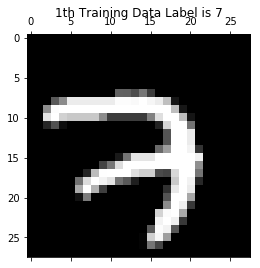

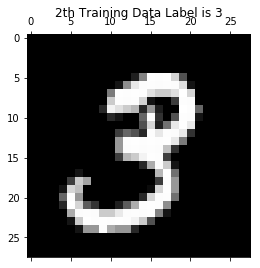

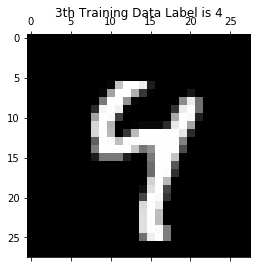

In [8]:
#查看圖片長的樣子
nsample = 1
randidx = np.random.randint(train_img.shape[0], size=nsample)
for i in [0, 1, 2]:
    #i是代表第幾張圖
    curr_img   = np.reshape(train_img[i, :], (28, 28)) # 28 by 28 matrix 
    #curr_label是該圖的標籤，train_label的形式為[0,0,0,1,0,0,0,0,0,0]，argmax可以找到該list中最大值的index所以是3
    curr_label = np.argmax(train_label[i, :] ) # Label
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title("" + str(i + 1) + "th Training Data " 
              + "Label is " + str(curr_label))
plt.show()    

In [65]:

x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
#y是預測的資料
y = tf.matmul(x, W) + b

#為了訓練模型，需要告訴model哪種結果是好的，壞的結果以cost、loss function
#此處使用cross-entropy方式來定義loss
y_ = tf.placeholder(tf.float32, [None, 10])
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
#softmax_cross_entropy_with_logits logits參數是預測資料，labels是實際資料
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = y,labels = y_)
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

#隨機取mnist的100筆資料來訓練
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, {x: batch_xs, y_: batch_ys})
# print(x[1])    
# for i in [0,1,2]:
#     curr_img   = np.reshape(x[i, :], (28, 28))
#     curr_label = np.argmax(y[i, :] ) # Label
#     plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
#     plt.title("" + str(i + 1) + "th Training Data " 
#               + "Label is " + str(curr_label))
#print boolean for each equation    
#y是預測的結果，y_是實際結果
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#print出準確度
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
#print預測結果和實際結果
for i in range(10):
    print(sess.run((tf.argmax(y[i,:]),tf.argmax(y_[i,:])),feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
  

0.8851
(7, 7)
(2, 2)
(1, 1)
(0, 0)
(4, 4)
(1, 1)
(4, 4)
(9, 9)
(6, 5)
(9, 9)


# improving the accuracy for MNIST by CNN

In [ ]:
#numpy的矩陣運算會以python以外的語言運算(高效)，但每次運算都要轉換成別種語言會有很多overhead(額外支出)，尤其是在GPU和分散式架構上
#tf也是以python以外的預言來運算，但是是一次運算一個階段，所以可減少overhead，類似描述一個tf的流程圖
import tensorflow as tf
sess = tf.InteractiveSession()
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = 'SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_conv, labels = y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
#跑20000次才夠
for i in range(200):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.2
